# pycobra and scikit-learn

This notebook demonstrates pycobras integration with the scikit-learn ecosystem.
We will also give an example of pycobra's performance on some real world data-sets.

In [1]:
from pycobra.cobra import Cobra
from pycobra.ewa import Ewa
from pycobra.diagnostics import Diagnostics
from pycobra.visualisation import Visualisation
import numpy as np
%matplotlib inline

Let's set up a synthetic data-set just to show that the COBRA estimator is scikit-learn compatible.

In [2]:
# setting up our random data-set
rng = np.random.RandomState(1)

# D1 = train machines; D2 = create COBRA; D3 = calibrate epsilon, alpha; D4 = testing
n_features = 20
D1, D2, D3, D4 = 200, 200, 200, 200
D = D1 + D2 + D3 + D4
X = rng.uniform(-1, 1, D * n_features).reshape(D, n_features)
Y = np.power(X[:,1], 2) + np.power(X[:,3], 3) + np.exp(X[:,10]) 
# Y = np.power(X[:,0], 2) + np.power(X[:,1], 3)

# training data-set
X_train = X[:D1 + D2]
X_test = X[D1 + D2 + D3:D1 + D2 + D3 + D4]
X_eps = X[D1 + D2:D1 + D2 + D3]
# for testing
Y_train = Y[:D1 + D2]
Y_test = Y[D1 + D2 + D3:D1 + D2 + D3 + D4]
Y_eps = Y[D1 + D2:D1 + D2 + D3]

Similar to other scikit-learn estimators, we set up our machine by creating an object and then fitting it. 

In [3]:
cobra = Cobra(random_state=rng)

In [4]:
cobra.fit(X_train, Y_train, epsilon=0.5)

Cobra(random_state=<mtrand.RandomState object at 0x1112cbd70>)

We now see if our object can fit into the scikit-learn pipeline and GridSearch - and it can!

In [5]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(Cobra) #passes

### Exponentially Weighted Average Aggregate

Let us also demonstrate the EWA predictor. You can read more about it over here in the [paper](http://www.crest.fr/ckfinder/userfiles/files/pageperso/tsybakov/DTcolt2007.pdf) by A. Dalalyan and A.B. Tsybakov. 

In [6]:
ewa = Ewa()

If we fit Ewa by also passing in `X_beta` and `y_beta`, we get a beta value optimised to the data passed.

In [7]:
ewa.fit(X_train, Y_train, X_beta=X_eps, y_beta=Y_eps)

Ewa(random_state=None)

In [8]:
check_estimator(Ewa) #passes

EWA assigns weights to each machine based on it's MSE. We can check the weights of each machine with the `plot_machine_weights` method.

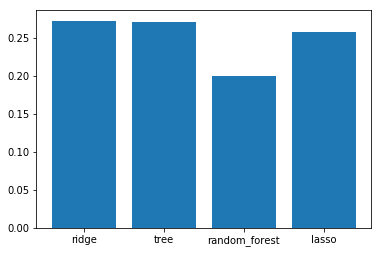

In [9]:
ewa.plot_machine_weights()

In [10]:
ewa.machine_weight

{'lasso': 0.25789197031858291,
 'random_forest': 0.19942120251648163,
 'ridge': 0.27214372062332032,
 'tree': 0.27054310654161523}

Like the Cobra estimator, Ewa is also a scikit-learn compatible estimator. It also fits into the Visualisation class, like demonstrated in the [notebook](https://github.com/bhargavvader/pycobra/blob/master/notebooks/visualise.ipynb). 

### Predicting?

Like the other scikit-learn predictors, we estimate on data by simply using the `predict()` method.

In [11]:
query = X_test[0].reshape(1, -1)

In [12]:
cobra.predict(query)

array([ 0.6896518])

In [13]:
ewa.predict(query)

array([ 0.68324243])

### Why pycobra?

There are scikit-learn estimators which already perform well in basic regression tasks - why use pycobra?
The Cobra estimator has the advantage of a theoretical bound on its performance - this means it is supposed to perform at least as well as the estimators used to create it, up to a remainder term which decays to zero. The Ewa estimator also benefits from similar bounds.

pycobra also lets you compare the scikit-learn estimators used in the aggregation - unlike the ensemble methods for regression which scikit-learn has, pycobra's algorithms is actually built on other scikit-learn like estimators. 

### pycobra for classification

pycobra also implements the classification algorithm as described by Mojirsheibani [1999] Combining Classifiers via Discretization, Journal of the American Statistical Association. 

In [14]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
bc = datasets.load_breast_cancer()
X = bc.data[:-20]
y = bc.target[:-20]
X_test = bc.data[-20:]
y_test = bc.target[-20:]

In [15]:
from pycobra.classifiercobra import ClassifierCobra
check_estimator(ClassifierCobra)

In [16]:
cc = ClassifierCobra()

In [17]:
cc.fit(X, y)

ClassifierCobra(random_state=None)

In [18]:
cc.predict(X_test)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.])

ClassifierCobra has very good theoretical bounds - let's see how it works in a practical case.

In [19]:
cc_diag = Diagnostics(cc, X_test, y_test)

In [20]:
cc_diag.load_errors()

In [22]:
cc_diag.machine_error

{'ClassifierCobra': 1.0,
 'knn': 1.0,
 'sgd': 0.90000000000000002,
 'svm': 0.69999999999999996,
 'tree': 0.94999999999999996}

Quite well!

### Real-world datasets

We have demonstrated in the regression notebook how pycobra works on synthetic data-sets. Let's see pycobra in action on some scikit-learn regression datasets.

In [ ]:
diabetes = datasets.load_diabetes()

diabetes_X_train = diabetes.data[:-40]
diabetes_X_test = diabetes.data[-20:]
# part of the data to find an appropriate epsilon
diabetes_X_eps = diabetes.data[-40:-20]

diabetes_y_train = diabetes.target[:-40]
diabetes_y_test = diabetes.target[-20:]
diabetes_y_eps = diabetes.target[-40:-20]

We're unaware of what epsilon value to choose for our data-sets so by passing `X_eps` and `y_eps` we can get an idea of what might be a good epsilon value. 

In [ ]:
COBRA_diabetes = Cobra()
COBRA_diabetes.fit(diabetes_X_train, diabetes_y_train, X_epsilon=diabetes_X_eps, y_epsilon=diabetes_y_eps)

Predicting using the COBRA predictor is again similar to using a scikit-learn estimator.

In [ ]:
COBRA_diabetes.predict(diabetes_X_test)

Let's compare our MSEs using the diagnostics class now.

In [ ]:
cobra_diagnostics = Diagnostics(COBRA_diabetes, diabetes_X_test, diabetes_y_test, load_MSE=True)

In [ ]:
cobra_diagnostics.machine_MSE

Let us similarily use COBRA on the Boston housing data set.

In [ ]:
boston = datasets.load_boston()

boston_X_train = boston.data[:-40]
boston_X_test = boston.data[-20:]
boston_X_eps = boston.data[-40:-20]

boston_y_train = boston.target[:-40]
boston_y_test = boston.target[-20:]
boston_y_eps = boston.target[-40:-20]

In [ ]:
COBRA_boston = Cobra()
COBRA_boston.fit(boston_X_train, boston_y_train, X_epsilon=boston_X_eps, y_epsilon=boston_y_eps)

In [ ]:
cobra_diagnostics = Diagnostics(COBRA_boston, boston_X_test, boston_y_test, load_MSE=True)

In [ ]:
cobra_diagnostics.machine_MSE